In [1]:
from pathlib import Path
from loguru import logger
from tqdm import tqdm
import sys, os, time
from datetime import timedelta
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.interpolate

from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure as MS_SSIM
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.regression import MeanAbsoluteError as MAE

from pathlib import Path

ADDR_ROOT = Path("/root/LHAI")
ADDR_CODE = ADDR_ROOT / "codes"   # 你的 codes 目录
sys.path.append(str(ADDR_ROOT))
sys.path.append(str(ADDR_CODE))

logger.success(f"ADDR_ROOT set to: {ADDR_ROOT}")
logger.success(f"ADDR_CODE  set to: {ADDR_CODE}")

from codes.config.config_diffusion import EvalConfig
from codes.function.Dataset import ImageDataset
import codes.function.Loss as lossfunction
from codes.function.Log import log
import codes.function.Train as Train
from codes.models.DIFFUSION import EnhancedUNetWrapper, Diffusion, positional_encoding, prepare_data
from torch.utils.data import Subset

2025-09-09 20:23:45.709 | SUCCESS  | __main__:<module>:29 - ADDR_ROOT set to: /root/LHAI
2025-09-09 20:23:45.713 | SUCCESS  | __main__:<module>:30 - ADDR_CODE  set to: /root/LHAI/codes
2025-09-09 20:23:45.719 | SUCCESS  | codes.config.config_diffusion:<module>:11 - ADDR_CONFIG is: /root/LHAI/codes/config
2025-09-09 20:23:45.720 | INFO     | codes.config.config_diffusion:<module>:12 - ADDR_ROOT is: /root/LHAI
2025-09-09 20:23:45.725 | SUCCESS  | codes.config.config_cnn:<module>:11 - ADDR_CONFIG is: /root/LHAI/codes/config
2025-09-09 20:23:45.726 | INFO     | codes.config.config_cnn:<module>:12 - ADDR_ROOT is: /root/LHAI


In [2]:
data_path = '/root/autodl-fs/xingwei_10000_64_train_v1.npy'
frac = 0.8
batch_size = 64

filetmp = np.load(data_path,allow_pickle=True)
filelen = filetmp.shape[0]
del filetmp
NUM_TO_LEARN = int(filelen)

dataset = ImageDataset(NUM_TO_LEARN,data_path,inverse=False)
train_size = int(frac * len(dataset))
test_size  = len(dataset) - train_size

train_indices = list(range(0, train_size))
test_indices  = list(range(train_size, len(dataset)))

trainset = Subset(dataset, train_indices)
testset  = Subset(dataset, test_indices)

trainloader = DataLoader(trainset, shuffle=False, batch_size=batch_size)
testloader  = DataLoader(testset,  shuffle=False, batch_size=batch_size)

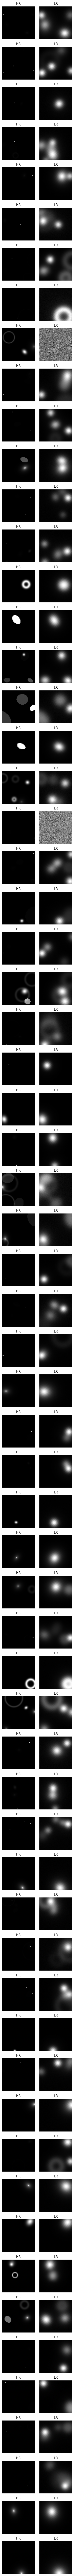

In [13]:
import matplotlib.pyplot as plt

def get_batch(loader, k=0):
    it = iter(loader)
    for _ in range(k+1):  # k=0 → 第1个batch，k=1 → 第2个batch
        batch = next(it)
    return batch

# 示例：取第二个 batch
hr_batch, lr_batch = get_batch(trainloader, k=0)

n_images = 64  # 要展示的数量
fig, axes = plt.subplots(n_images, 2, figsize=(4, 2 * n_images))

for i in range(n_images):
    # HR 图
    axes[i, 1].imshow(hr_batch[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i, 1].set_title("LR")
    axes[i, 1].axis("off")

    # LR 图
    axes[i, 0].imshow(lr_batch[i].squeeze().cpu().numpy(), cmap="gray")
    axes[i, 0].set_title("HR")
    axes[i, 0].axis("off")

plt.tight_layout()
plt.show()